#### task 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        self.encoder = self._build_layer(input_size, bottleneck_size, hidden_size, layers)
        self.decoder = self._build_layer(bottleneck_size, input_size, hidden_size, layers, reverse=True)

    def _build_layer(self, input_dim, output_dim, hidden_size, layers, reverse=False):
        layer_list = []
        if reverse:
            layer_list.append(nn.Linear(input_dim, hidden_size)) # input_dim is bottleneck_size here
            layer_list.append(nn.ReLU())
            for _ in range(layers - 1):
                layer_list.append(nn.Linear(hidden_size, hidden_size))
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(hidden_size, output_dim))
        else:
            layer_list.append(nn.Linear(input_dim, hidden_size))
            layer_list.append(nn.ReLU())
            for _ in range(layers - 1):
                layer_list.append(nn.Linear(hidden_size, hidden_size))
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(hidden_size, output_dim))
        return nn.Sequential(*layer_list)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
def generate_moons(noise=0.1, n_samples=1000):
    data, _ = make_moons(n_samples=n_samples, noise=noise)
    return torch.tensor(data, dtype=torch.float32)

In [4]:
# Task 1.1
def train_autoencoder_and_display_tables(hidden_sizes, layer_counts, data, epochs=10, batch_size=64, lr=0.001,
                                         entries_per_table=15, num_columns=2):

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()

    results = {}
    print(f"{'Training Autoencoder with Different Hyperparameters':^80}")
    print("=" * 80)

    for hidden_size in hidden_sizes:
        for layers in layer_counts:
            autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=layers)
            optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

            # Training
            for epoch in range(epochs):
                total_loss = 0
                for batch in dataloader:
                    optimizer.zero_grad()
                    reconstructed = autoencoder(batch)
                    loss = criterion(reconstructed, batch)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(dataloader)

                # Storing results
                if (hidden_size, layers) not in results:
                    results[(hidden_size, layers)] = []
                results[(hidden_size, layers)].append(avg_loss)

    results_list = [
        (hidden_size, layers, epoch + 1, loss)
        for (hidden_size, layers), losses in results.items()
        for epoch, loss in enumerate(losses)
    ]

    # For Side-by-Side Tables
    chunks = [results_list[i:i + entries_per_table] for i in range(0, len(results_list), entries_per_table)]
    rows = [chunks[i:i + num_columns] for i in range(0, len(chunks), num_columns)]


    for row in rows:
        headers = [
            f"{'Hidden Size':<12}{'Layers':<8}{'Epoch':<8}{'Loss':<12}" for _ in row
        ]
        print("    ".join(headers))
        print("    ".join(["-" * 40 for _ in row]))

        for line_idx in range(entries_per_table):
            row_entries = []
            for chunk in row:
                if line_idx < len(chunk):
                    hidden_size, layers, epoch, loss = chunk[line_idx]
                    row_entries.append(f"{hidden_size:<12}{layers:<8}{epoch:<8}{loss:<12.6f}")
                else:
                    row_entries.append(" " * 40)
            print("    ".join(row_entries))

        print("\n")


    return results

# Data to Use
train_data = generate_moons(noise=0.1, n_samples=1000)
hidden_sizes = [16, 32, 64, 128]
layer_counts = [2, 3, 4]

# Training and getting table output
results = train_autoencoder_and_display_tables(
    hidden_sizes=hidden_sizes,
    layer_counts=layer_counts,
    data=train_data,
    epochs=10,
    batch_size=64,
    lr=0.001,
    entries_per_table=15,
    num_columns=2
)


              Training Autoencoder with Different Hyperparameters               
Hidden Size Layers  Epoch   Loss            Hidden Size Layers  Epoch   Loss        
----------------------------------------    ----------------------------------------
16          2       1       0.722025        16          3       6       0.489191    
16          2       2       0.624851        16          3       7       0.437804    
16          2       3       0.544481        16          3       8       0.367493    
16          2       4       0.474879        16          3       9       0.288951    
16          2       5       0.395249        16          3       10      0.225431    
16          2       6       0.314225        16          4       1       0.671753    
16          2       7       0.229894        16          4       2       0.629699    
16          2       8       0.170112        16          4       3       0.596667    
16          2       9       0.134460        16          4       4    

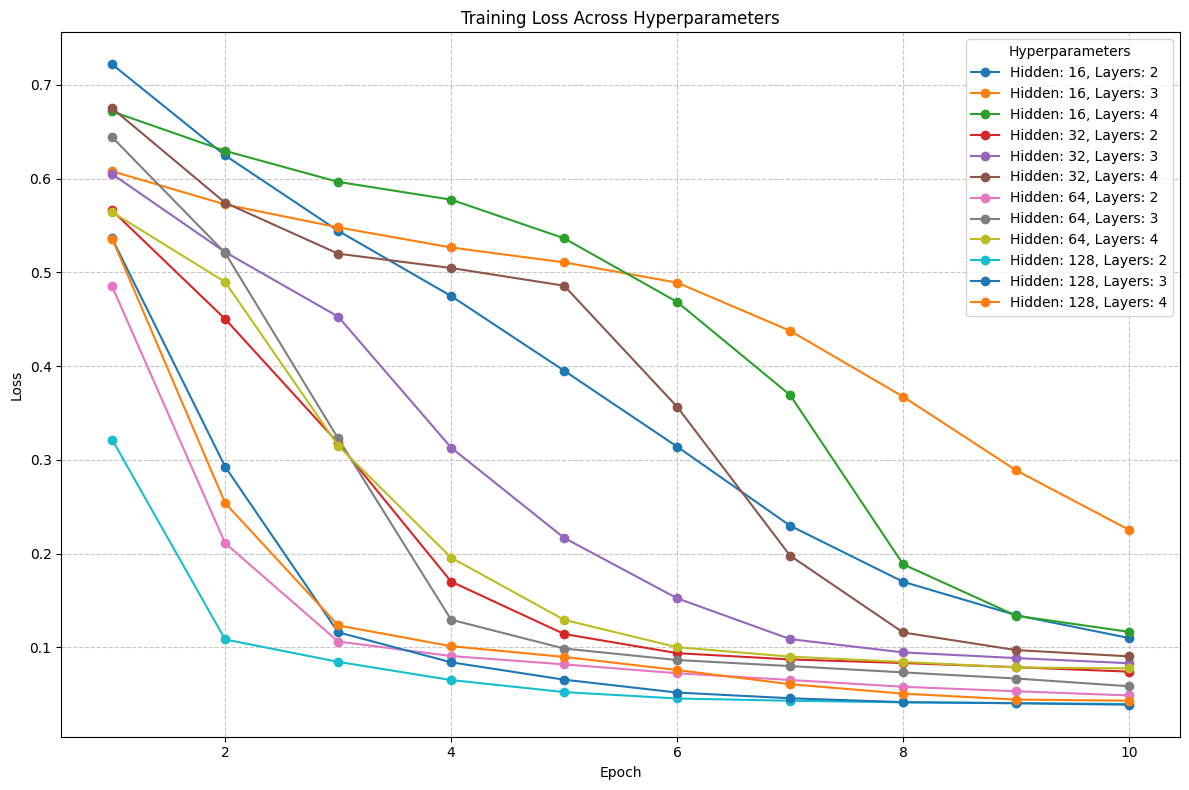

In [5]:
# Function to compare the loss across different Hyperparameters
def plot_loss_results(results):
    plt.figure(figsize=(12, 8))
    for (hidden_size, layers), losses in results.items():
        plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f"Hidden: {hidden_size}, Layers: {layers}")

    plt.title("Training Loss Across Hyperparameters")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(title="Hyperparameters", loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_loss_results(results)

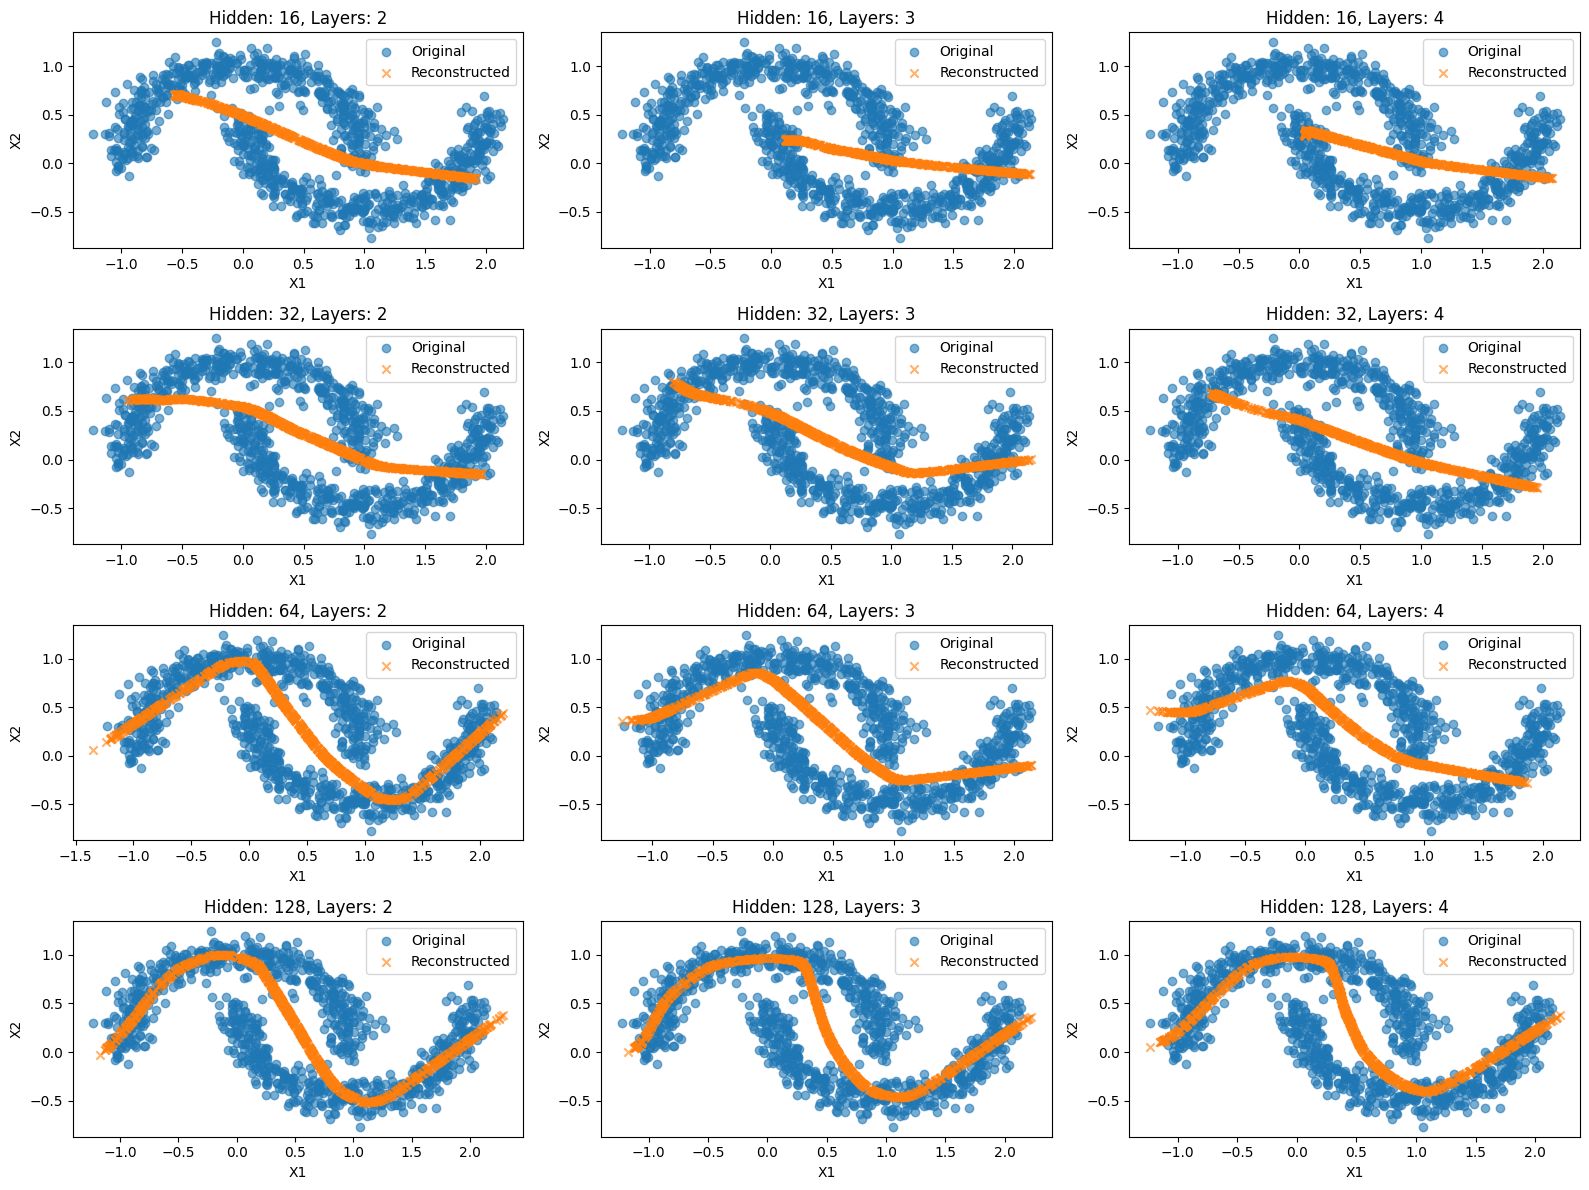

In [6]:
# Task 1.1
def plot_reconstructed_vs_original(data, hidden_sizes, layer_counts, epochs=10, batch_size=64, lr=0.001):

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
    original_points = data

    plt.figure(figsize=(16, 12))
    plot_idx = 1

    # Iterating over hyperparameter combinations
    for hidden_size in hidden_sizes:
        for layers in layer_counts:

            autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=layers)
            optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Training the Autoencoder
            autoencoder.train()
            for epoch in range(epochs):
                for batch in dataloader:
                    optimizer.zero_grad()
                    reconstructed = autoencoder(batch)
                    loss = criterion(reconstructed, batch)
                    loss.backward()
                    optimizer.step()

            autoencoder.eval()
            with torch.no_grad():
                reconstructed_points = autoencoder(original_points)

            # Plot
            plt.subplot(len(hidden_sizes), len(layer_counts), plot_idx)
            plt.scatter(original_points[:, 0], original_points[:, 1], alpha=0.6, label="Original")
            plt.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1], alpha=0.6, label="Reconstructed", marker='x')
            plt.title(f"Hidden: {hidden_size}, Layers: {layers}")
            plt.xlabel("X1")
            plt.ylabel("X2")
            plt.legend()
            plot_idx += 1

    plt.tight_layout()
    plt.show()

# Calling the function using the previous values
plot_reconstructed_vs_original(
    data=generate_moons(noise=0.1, n_samples=1000),
    hidden_sizes = [16, 32, 64, 128],
    layer_counts = [2, 3, 4],
    epochs=10,
    batch_size=64,
    lr=0.001
)

Investigating variations with SAME dataset:
Run 1: Reconstruction Error (MSE) = 0.037640
Run 2: Reconstruction Error (MSE) = 0.035971
Run 3: Reconstruction Error (MSE) = 0.036695
Run 4: Reconstruction Error (MSE) = 0.033989
Run 5: Reconstruction Error (MSE) = 0.040019

Investigating variations with DIFFERENT datasets:
Run 1: Reconstruction Error (MSE) = 0.040224
Run 2: Reconstruction Error (MSE) = 0.034658
Run 3: Reconstruction Error (MSE) = 0.038953
Run 4: Reconstruction Error (MSE) = 0.037941
Run 5: Reconstruction Error (MSE) = 0.038795


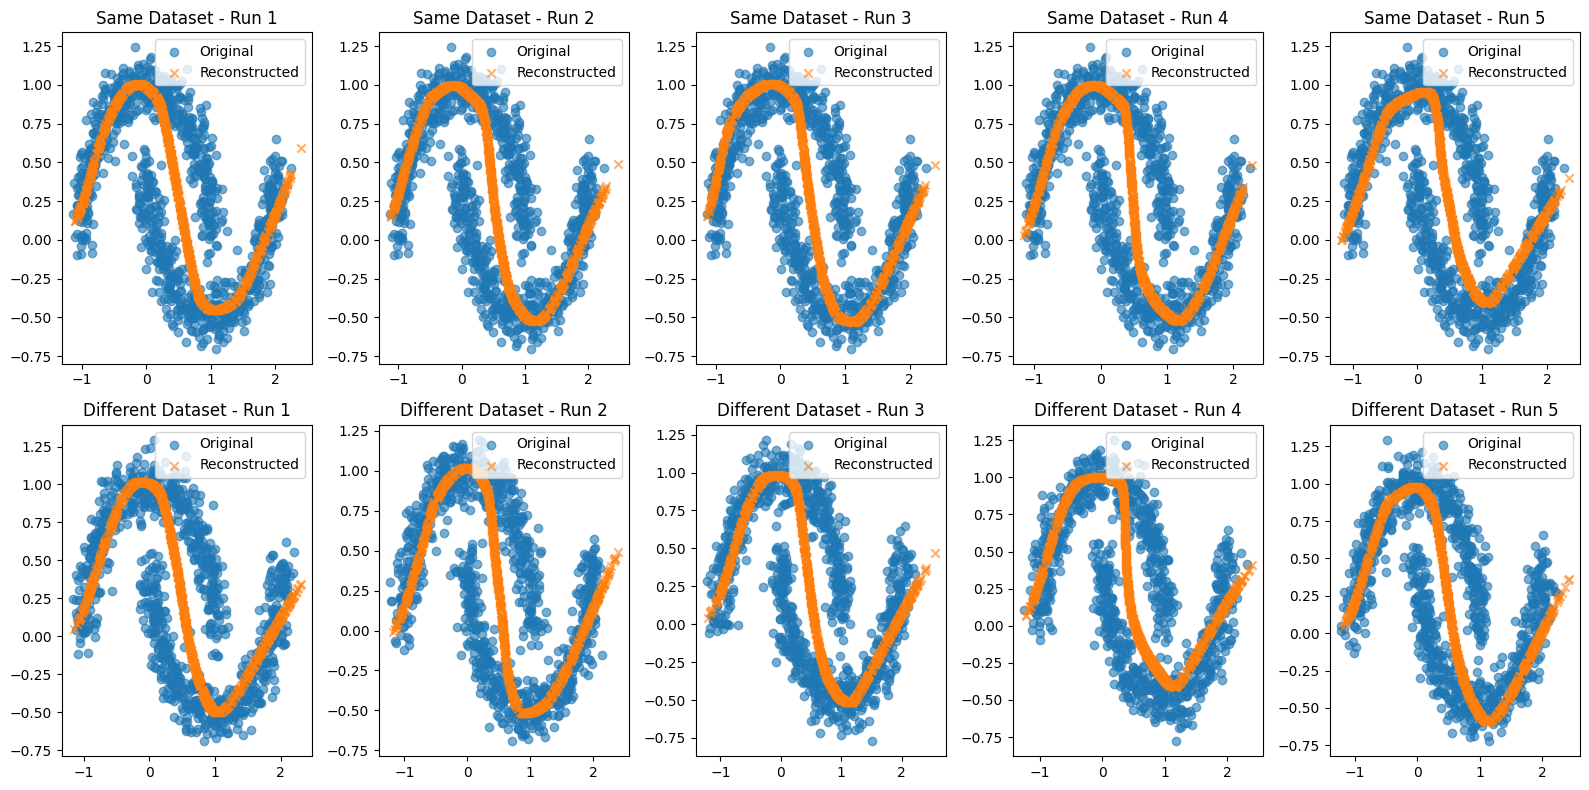


Summary of Reconstruction Errors:
Run     Same Dataset MSE    Different Dataset MSE
----------------------------------------
1       0.037640            0.040224            
2       0.035971            0.034658            
3       0.036695            0.038953            
4       0.033989            0.037941            
5       0.040019            0.038795            


In [7]:
# Task 1.2
def reconstruction_variation(best_hidden_size, best_layers, noise_level=0.1, epochs=10, batch_size=64, lr=0.001, runs=5):
    criterion = nn.MSELoss()

    # Reconstructing same dataset
    original_data = generate_moons(noise=noise_level, n_samples=1000)
    dataloader = torch.utils.data.DataLoader(original_data, batch_size=batch_size, shuffle=True)

    print("Investigating variations with SAME dataset:")
    same_dataset_errors = []
    same_dataset_reconstructions = []

    for run in range(runs):
        autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=best_hidden_size, layers=best_layers)
        optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

        # Training
        autoencoder.train()
        for epoch in range(epochs):
            for batch in dataloader:
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()

        # Error calculation
        autoencoder.eval()
        with torch.no_grad():
            reconstructed_points = autoencoder(original_data)
            mse = criterion(reconstructed_points, original_data).item()
            same_dataset_errors.append(mse)
            same_dataset_reconstructions.append(reconstructed_points)

        print(f"Run {run + 1}: Reconstruction Error (MSE) = {mse:.6f}")

    # Different dataset reconstruction
    print("\nInvestigating variations with DIFFERENT datasets:")
    diff_dataset_errors = []
    diff_dataset_reconstructions = []

    for run in range(runs):
        # Generating a new dataset for each run
        different_data = generate_moons(noise=noise_level, n_samples=1000)
        dataloader = torch.utils.data.DataLoader(different_data, batch_size=batch_size, shuffle=True)

        autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=best_hidden_size, layers=best_layers)
        optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

        # Train
        autoencoder.train()
        for epoch in range(epochs):
            for batch in dataloader:
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()

        # Error calculation
        autoencoder.eval()
        with torch.no_grad():
            reconstructed_points = autoencoder(different_data)
            mse = criterion(reconstructed_points, different_data).item()
            diff_dataset_errors.append(mse)
            diff_dataset_reconstructions.append(reconstructed_points)

        print(f"Run {run + 1}: Reconstruction Error (MSE) = {mse:.6f}")

    # Ploting for same dataset
    plt.figure(figsize=(16, 8))
    for i in range(runs):
        plt.subplot(2, runs, i + 1)
        plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, label="Original")
        plt.scatter(same_dataset_reconstructions[i][:, 0], same_dataset_reconstructions[i][:, 1], alpha=0.6, label="Reconstructed", marker='x')
        plt.title(f"Same Dataset - Run {i + 1}")
        plt.legend()

    # Ploting for different datasets
    for i in range(runs):
        plt.subplot(2, runs, runs + i + 1)
        different_data = generate_moons(noise=noise_level, n_samples=1000)
        plt.scatter(different_data[:, 0], different_data[:, 1], alpha=0.6, label="Original")
        plt.scatter(diff_dataset_reconstructions[i][:, 0], diff_dataset_reconstructions[i][:, 1], alpha=0.6, label="Reconstructed", marker='x')
        plt.title(f"Different Dataset - Run {i + 1}")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Summary
    print("\nSummary of Reconstruction Errors:")
    print(f"{'Run':<8}{'Same Dataset MSE':<20}{'Different Dataset MSE'}")
    print("-" * 40)
    for i in range(runs):
        print(f"{i + 1:<8}{same_dataset_errors[i]:<20.6f}{diff_dataset_errors[i]:<20.6f}")

# Using the function for best parameter setting
reconstruction_variation(
    best_hidden_size=128,
    best_layers=3,
    noise_level=0.1,
    epochs=10,
    batch_size=64,
    lr=0.001,
    runs=5
)

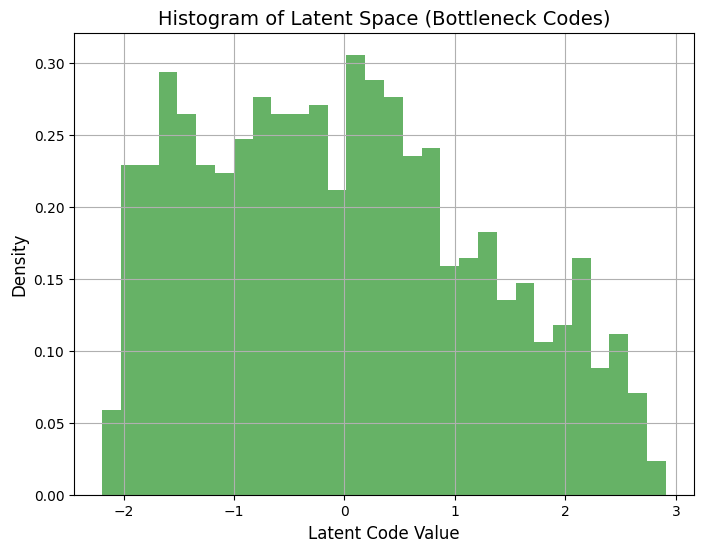

In [8]:
# Task 1.3

# Taking the best hyperparameter for autoencoder
autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=128, layers=2)

# Taking the data again
original_data = generate_moons(noise=0.1, n_samples=1000)
dataloader = torch.utils.data.DataLoader(original_data, batch_size=64, shuffle=True)

# Adam Optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10):
    for batch in dataloader:
        optimizer.zero_grad()
        reconstructed = autoencoder(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()

autoencoder.eval()
latent_codes = []

with torch.no_grad():
    for batch in dataloader:

        codes = autoencoder.encoder(batch)
        latent_codes.append(codes.numpy())


latent_codes = np.vstack(latent_codes)

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(latent_codes, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Latent Space (Bottleneck Codes)', fontsize=14)
plt.xlabel('Latent Code Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

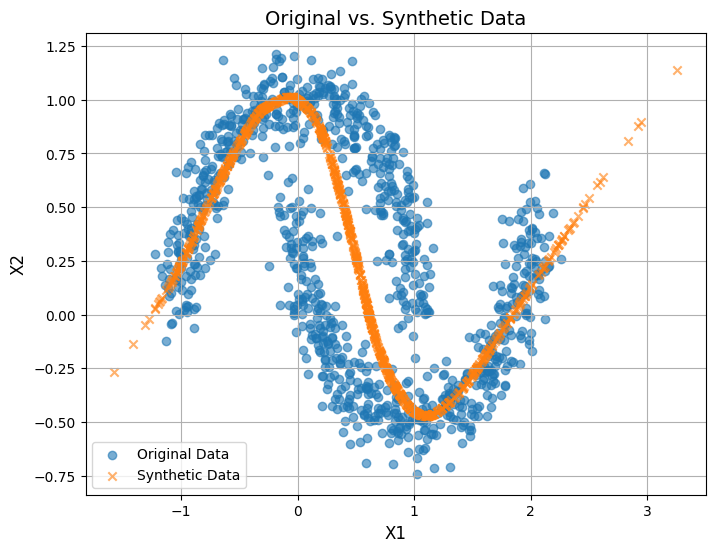

In [12]:
# Fitting Gaussian Mixture Model (GMM) to Latent Space
gmm = GaussianMixture(n_components=2)
gmm.fit(latent_codes)

# Sample synthetic data from GMM
n_samples = 1000
sampled_codes = gmm.sample(n_samples)[0]

synthetic_data = autoencoder.decoder(torch.tensor(sampled_codes, dtype=torch.float32))

plt.figure(figsize=(8, 6))
plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, label="Original Data")
plt.scatter(synthetic_data.detach().numpy()[:, 0],
            synthetic_data.detach().numpy()[:, 1],
            alpha=0.6, label="Synthetic Data", marker='x')
plt.title('Original vs. Synthetic Data', fontsize=14)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Reconstruction Error (MSE) on noisy test set (noise=0.2): 0.065754


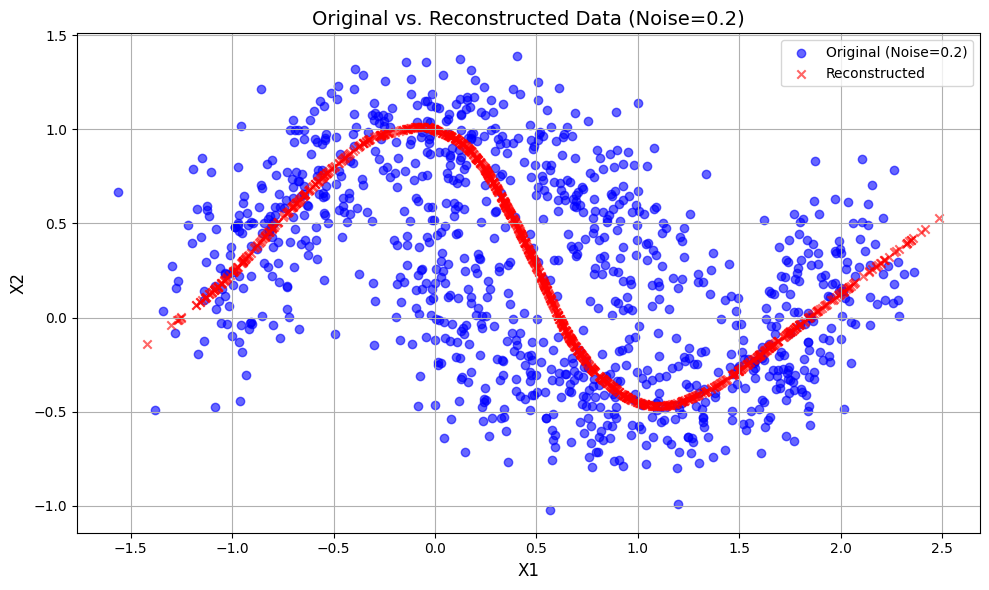

In [13]:
# Task 1.4-1.5
# Taking a new test set with noise level 0.2
test_data = generate_moons(noise=0.2, n_samples=1000)

autoencoder.eval()

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Collecting reconstructed data
reconstructed_data = []
with torch.no_grad():
    for batch in test_dataloader:
        reconstructed = autoencoder(batch)
        reconstructed_data.append(reconstructed)

reconstructed_data = torch.cat(reconstructed_data, dim=0).numpy()

# Calculating MSE between original test data and reconstructed data
mse = mean_squared_error(test_data, reconstructed_data)
print(f"Reconstruction Error (MSE) on noisy test set (noise=0.2): {mse:.6f}")

plt.figure(figsize=(10, 6))

plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.6, label="Original (Noise=0.2)", color='blue')

plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.6, label="Reconstructed", marker='x', color='red')

plt.title("Original vs. Reconstructed Data (Noise=0.2)", fontsize=14)
plt.xlabel("X1", fontsize=12)
plt.ylabel("X2", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### task 2

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class ResBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, x):
        return x + self.net(x)

class ResNetAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, num_blocks):
        super().__init__()
        
        # Encoder
        self.encoder_input = nn.Linear(input_size, hidden_size)
        self.encoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.encoder_output = nn.Linear(hidden_size, bottleneck_size)
        
        # Decoder
        self.decoder_input = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.decoder_output = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        h = self.encoder_input(x)
        for block in self.encoder_blocks:
            h = block(h)
        return self.encoder_output(h)
    
    def decode(self, z):
        h = self.decoder_input(z)
        for block in self.decoder_blocks:
            h = block(h)
        return self.decoder_output(h)
    
    def forward(self, x):
        return self.decode(self.encode(x))

def compute_kernel(x, y, bandwidths):
    """
    Compute sum of RBF kernels with different bandwidths
    """
    xx = x.unsqueeze(1)  # (N, 1, D)
    yy = y.unsqueeze(0)  # (1, M, D)
    distances = (xx - yy).pow(2).sum(2)  # (N, M)
    
    kernels = torch.zeros_like(distances)
    for bandwidth in bandwidths:
        kernels += torch.exp(-distances / (2 * bandwidth ** 2))
    
    return kernels

def compute_mmd(x, y, bandwidths):
    """
    Compute Maximum Mean Discrepancy between x and y distributions
    """
    x_kernel = compute_kernel(x, x, bandwidths)
    y_kernel = compute_kernel(y, y, bandwidths)
    xy_kernel = compute_kernel(x, y, bandwidths)
    
    N = x_kernel.size(0)
    M = y_kernel.size(0)
    
    xx = x_kernel.sum() / (N * (N - 1))  # exclude diagonal
    yy = y_kernel.sum() / (M * (M - 1))  # exclude diagonal
    xy = xy_kernel.mean()
    
    mmd = xx + yy - 2 * xy
    return mmd

def train_mmd_autoencoder(model, train_loader, test_loader, epochs, 
                         lr=0.001, bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6], 
                         mmd_weight=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    reconstruction_criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            batch_size = batch_data.size(0)
            
            optimizer.zero_grad()
            
            # Forward pass
            codes = model.encode(batch_data)
            reconstructed = model.decode(codes)
            
            # Compute reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, batch_data)
            
            # Compute MMD loss
            reference = torch.randn_like(codes)  # Sample from standard normal
            mmd_loss = compute_mmd(codes, reference, bandwidths)
            
            # Total loss
            loss = recon_loss + mmd_weight * mmd_loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                codes = model.encode(batch_data)
                reference = torch.randn_like(codes)
                
                recon_loss = reconstruction_criterion(reconstructed, batch_data)
                mmd_loss = compute_mmd(codes, reference, bandwidths)
                loss = recon_loss + mmd_weight * mmd_loss
                
                test_loss += loss.item()
                
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

def generate_samples(model, n_samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, 2).to(device)
        # Generate samples through decoder
        samples = model.decode(z).cpu().numpy()
    return samples

# Example usage:
def run_mmd_experiment(n_samples=1000, noise=0.1, hidden_size=64, num_blocks=3,
                      epochs=100, batch_size=32, mmd_weight=0.1):
    # Prepare data
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Create model
    model = ResNetAutoencoder(
        input_size=2,
        bottleneck_size=2,  # No dimensional reduction
        hidden_size=hidden_size,
        num_blocks=num_blocks
    )
    
    # Train model
    train_losses, test_losses = train_mmd_autoencoder(
        model, 
        train_loader, 
        test_loader, 
        epochs=epochs,
        mmd_weight=mmd_weight
    )
    
    # Generate and visualize results
    synthetic_samples = generate_samples(model, n_samples=1000)
    
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original data
    ax1.scatter(X_test[:, 0], X_test[:, 1], alpha=0.5)
    ax1.set_title('Original Data')
    
    # Reconstructions
    model.eval()
    with torch.no_grad():
        reconstructed = model(torch.FloatTensor(X_test).to(model.decoder_output.weight.device))
        reconstructed = reconstructed.cpu().numpy()
    ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5)
    ax2.set_title('Reconstructions')
    
    # Generated samples
    ax3.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], alpha=0.5)
    ax3.set_title('Generated Samples')
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses

Epoch [10/100], Train Loss: 0.0399, Test Loss: 0.0532
Epoch [20/100], Train Loss: 0.0377, Test Loss: 0.0482
Epoch [30/100], Train Loss: 0.0360, Test Loss: 0.0469
Epoch [40/100], Train Loss: 0.0347, Test Loss: 0.0503
Epoch [50/100], Train Loss: 0.0345, Test Loss: 0.0459
Epoch [60/100], Train Loss: 0.0347, Test Loss: 0.0452
Epoch [70/100], Train Loss: 0.0327, Test Loss: 0.0497
Epoch [80/100], Train Loss: 0.0335, Test Loss: 0.0487
Epoch [90/100], Train Loss: 0.0339, Test Loss: 0.0453
Epoch [100/100], Train Loss: 0.0342, Test Loss: 0.0465


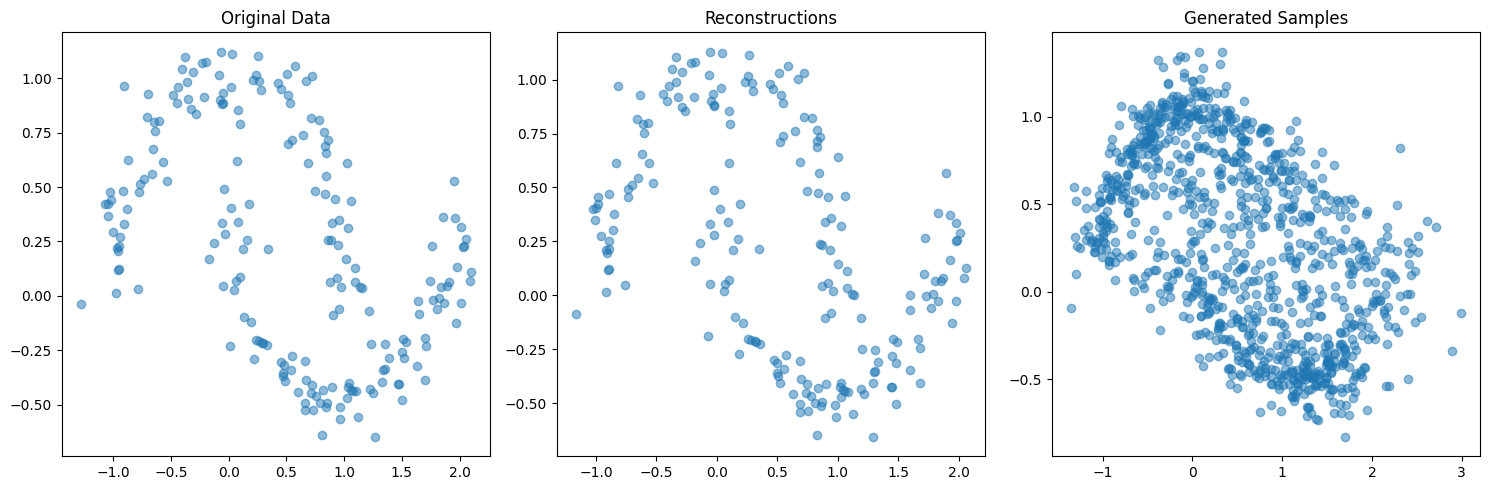

In [15]:
model, train_losses, test_losses = run_mmd_experiment(
    n_samples=1000,
    noise=0.1,
    hidden_size=64,
    num_blocks=3,
    epochs=100,
    mmd_weight=0.1
)

<!-- We continue with the two mo ons dataset, but this time b ottleneck size 2. Since training now lacks
the regularizing eect of the lossy compression (which enforces the co des to fo cus on the imp ortant
data features), we need an additional loss term. We use the maximum mean discrepancy (MMD)
b etween the co de distribution (i.e. the push-forward through the enco der) and a 2-dimensional
standard normal. This loss pulls the co de distribution towards the standard normal, so that we can
later generate synthetic data by sampling from the standard normal and transform the samples
through the deco der. The kernel for MMD shall b e a sum of squared exp onentials or inverse multi-
quadratics at multiple bandwidths (the numb er and values of the bandwidths are hyp erparameters
 use three to seven bandwidths such that each value is twice the next smaller one). The training
loss is a weighted sum of the squared reconstruction error and the MMD, with the weight b eing yet
another hyp erparameter.
Use the auto enco der from task 1 (with bottleneck_size=2) or implement a residual network (ResNet
 it gave b etter results in our exp eriments). Recall that a ResNet consists of L residual blo cks
computing zl= zl−1 + fl(zl−1) for l = 1, ..., L, where z0 are the original data. The fl() are fully
connected networks with one or two hidden layers whose width is typically larger than the input
dimension. Implement a new function train_mmd_autoencoder() and train the mo del at noise level 0.1.
Visualize the reconstructed vs. original data, and the co de distribution. Check that the reconstruc-
tion error is much less than what you got with a b ottleneck of size 1. Generate synthetic data by
passing standard normal samples through the deco der and visualize their quality. Comment on your
ndings -->

Comparison of the results of the autoencoder with bottleneck size 1 and 2.

- The autoencoder with bottleneck size 2 has a lower reconstruction error than the autoencoder with bottleneck size 1. 

- The autoencoder with bottleneck size 2 has a higher capacity to learn the data distribution and can reconstruct the data more accurately. 

- The autoencoder with bottleneck size 2 also has a more complex architecture, which allows it to capture more features of the data.

#### task 3

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

class DigitsAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        
        # Build encoder
        encoder_layers = []
        # First layer
        encoder_layers.extend([
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        ])
        
        # Middle layers
        for _ in range(layers - 1):
            encoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])
            
        # Bottleneck layer
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        
        # Build decoder
        decoder_layers = []
        # First layer from bottleneck
        decoder_layers.extend([
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU()
        ])
        
        # Middle layers
        for _ in range(layers - 1):
            decoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])
            
        # Output layer
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

def prepare_digits_data(batch_size=32):
    # Load digits dataset
    digits = load_digits()
    X = digits.data.astype('float32')
    y = digits.target
    
    # Normalize the data
    X = X / 16.0  # Scale to [0,1]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create dataloaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, X_train, X_test, y_train, y_test

def train_digits_autoencoder(model, train_loader, test_loader, epochs, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                loss = criterion(reconstructed, batch_data)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
            
    return train_losses, test_losses

def visualize_reconstructions(model, X_test, n_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test[:n_samples]).to(device)
        reconstructed = model(X_test_tensor).cpu().numpy()
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 1.5, 3))
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(X_test[i].reshape(8, 8), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
            
        # Reconstructed
        axes[1, i].imshow(reconstructed[i].reshape(8, 8), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

def analyze_autoencoder(bottleneck_size, hidden_size=128, layers=2, epochs=100):
    # Prepare data
    train_loader, test_loader, X_train, X_test, y_train, y_test = prepare_digits_data()
    
    # Create and train model
    model = DigitsAutoencoder(64, bottleneck_size, hidden_size, layers)
    train_losses, test_losses = train_digits_autoencoder(model, train_loader, test_loader, epochs)
    
    # Visualize reconstructions
    visualize_reconstructions(model, X_test)
    
    # Get reconstructions for all test data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        reconstructed_test = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()
    
    # Train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get predictions for original and reconstructed data
    orig_pred = rf.predict(X_test)
    recon_pred = rf.predict(reconstructed_test)
    
    # Calculate prediction agreement
    agreement = np.mean(orig_pred == recon_pred)
    print(f"\nPrediction agreement between original and reconstructed: {agreement:.2%}")
    
    # For bottleneck_size=2, visualize latent space
    if bottleneck_size == 2:
        plt.figure(figsize=(10, 8))
        with torch.no_grad():
            latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()
        plt.scatter(latent[:, 0], latent[:, 1], c=y_test, cmap='tab10')
        plt.colorbar(label='Digit')
        plt.title('2D Latent Space')
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.show()
    
    # Generate synthetic data using GMM
    with torch.no_grad():
        latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()
    
    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(latent)
    
    # Generate synthetic samples
    synthetic_latent = gmm.sample(n_samples=20)[0]
    with torch.no_grad():
        synthetic_digits = model.decode(torch.FloatTensor(synthetic_latent).to(device)).cpu().numpy()
    
    # Visualize synthetic digits
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        ax.axis('off')
    plt.suptitle('Synthetic Digits')
    plt.tight_layout()
    plt.show()
    
    # Classify synthetic data
    synthetic_pred = rf.predict(synthetic_digits)
    print("\nPredicted classes for synthetic digits:", synthetic_pred)
    
    return model, train_losses, test_losses

# Function to run experiments with different bottleneck sizes
def run_bottleneck_experiments():
    bottleneck_sizes = [2, 4, 8]
    for size in bottleneck_sizes:
        print(f"\nRunning experiment with bottleneck size {size}")
        analyze_autoencoder(size)


Running experiment with bottleneck size 2
Epoch [10/100], Train Loss: 0.0424, Test Loss: 0.0423
Epoch [20/100], Train Loss: 0.0351, Test Loss: 0.0360
Epoch [30/100], Train Loss: 0.0319, Test Loss: 0.0336
Epoch [40/100], Train Loss: 0.0296, Test Loss: 0.0320
Epoch [50/100], Train Loss: 0.0278, Test Loss: 0.0312
Epoch [60/100], Train Loss: 0.0267, Test Loss: 0.0309
Epoch [70/100], Train Loss: 0.0260, Test Loss: 0.0307
Epoch [80/100], Train Loss: 0.0254, Test Loss: 0.0306
Epoch [90/100], Train Loss: 0.0250, Test Loss: 0.0305
Epoch [100/100], Train Loss: 0.0246, Test Loss: 0.0301


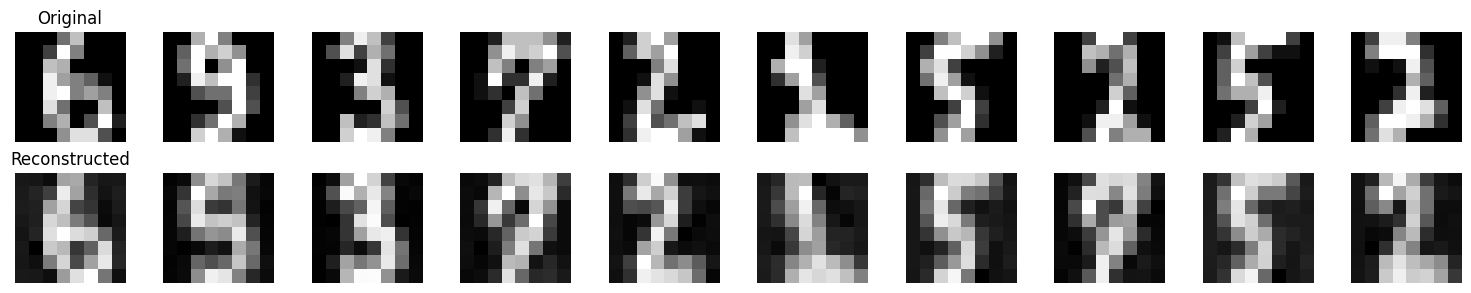


Prediction agreement between original and reconstructed: 88.33%


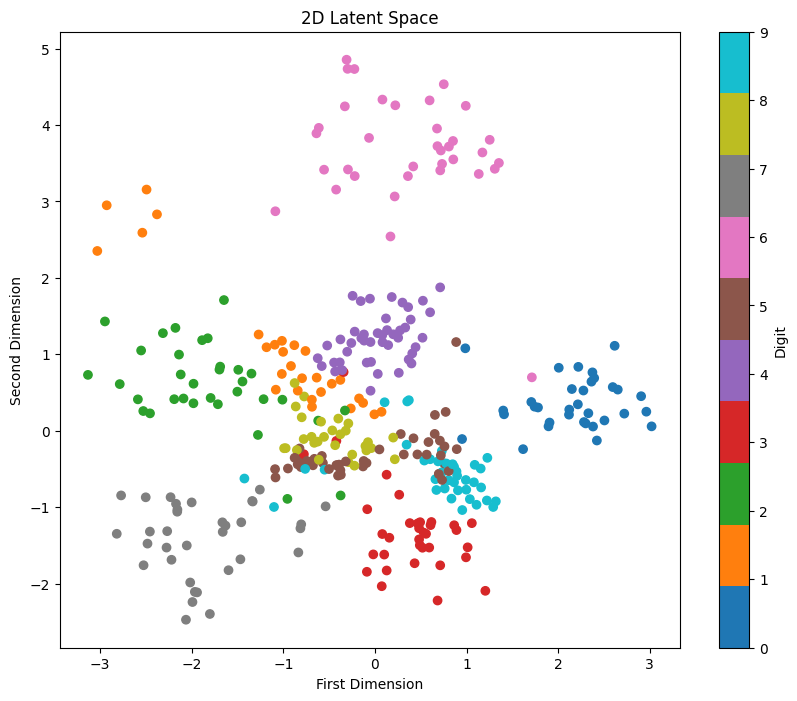

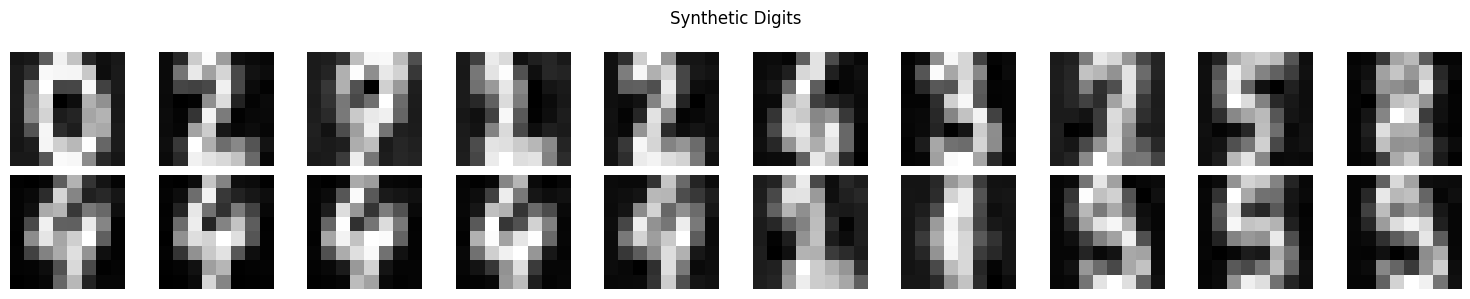


Predicted classes for synthetic digits: [0 2 7 2 2 6 3 2 5 8 4 4 4 4 4 2 1 9 9 9]

Running experiment with bottleneck size 4
Epoch [10/100], Train Loss: 0.0291, Test Loss: 0.0304
Epoch [20/100], Train Loss: 0.0232, Test Loss: 0.0247
Epoch [30/100], Train Loss: 0.0212, Test Loss: 0.0233
Epoch [40/100], Train Loss: 0.0196, Test Loss: 0.0222
Epoch [50/100], Train Loss: 0.0185, Test Loss: 0.0217
Epoch [60/100], Train Loss: 0.0176, Test Loss: 0.0206
Epoch [70/100], Train Loss: 0.0168, Test Loss: 0.0203
Epoch [80/100], Train Loss: 0.0162, Test Loss: 0.0197
Epoch [90/100], Train Loss: 0.0158, Test Loss: 0.0200
Epoch [100/100], Train Loss: 0.0152, Test Loss: 0.0191


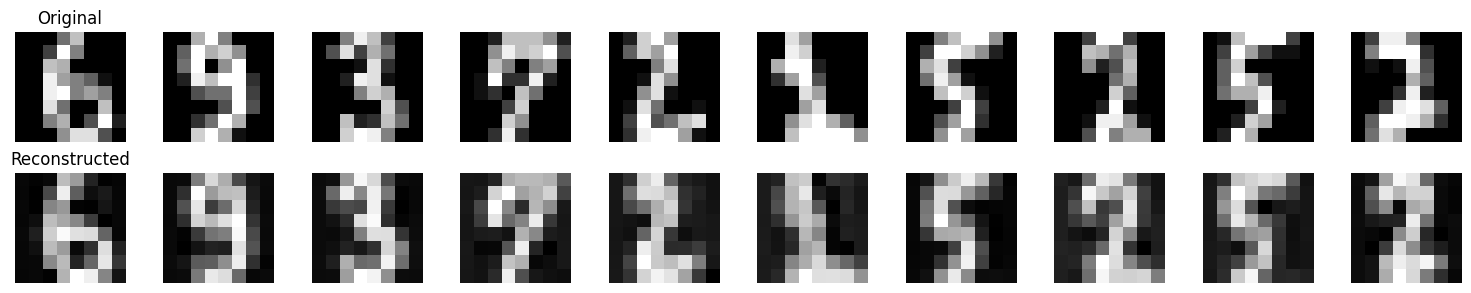


Prediction agreement between original and reconstructed: 94.17%


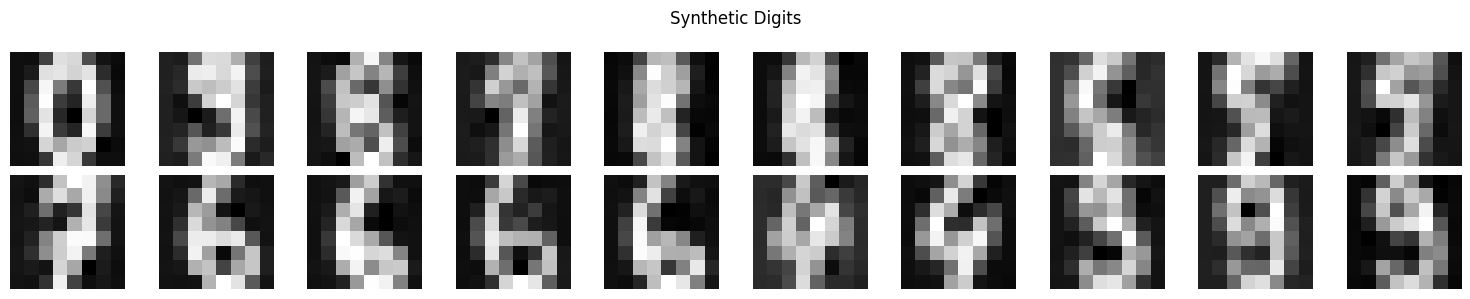


Predicted classes for synthetic digits: [0 9 8 8 8 8 8 5 5 5 7 6 6 6 6 4 4 3 9 9]

Running experiment with bottleneck size 8
Epoch [10/100], Train Loss: 0.0216, Test Loss: 0.0214
Epoch [20/100], Train Loss: 0.0147, Test Loss: 0.0156
Epoch [30/100], Train Loss: 0.0126, Test Loss: 0.0138
Epoch [40/100], Train Loss: 0.0114, Test Loss: 0.0132
Epoch [50/100], Train Loss: 0.0106, Test Loss: 0.0126
Epoch [60/100], Train Loss: 0.0100, Test Loss: 0.0124
Epoch [70/100], Train Loss: 0.0095, Test Loss: 0.0120
Epoch [80/100], Train Loss: 0.0092, Test Loss: 0.0122
Epoch [90/100], Train Loss: 0.0088, Test Loss: 0.0118
Epoch [100/100], Train Loss: 0.0086, Test Loss: 0.0117


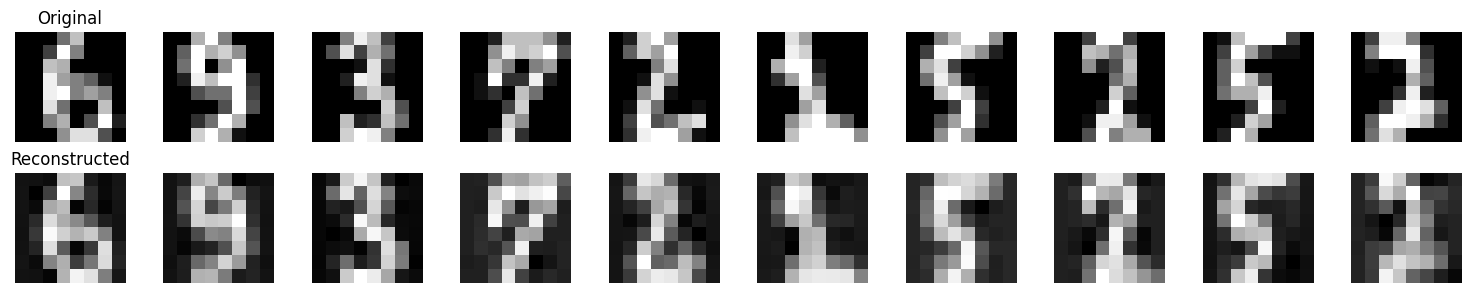


Prediction agreement between original and reconstructed: 96.39%


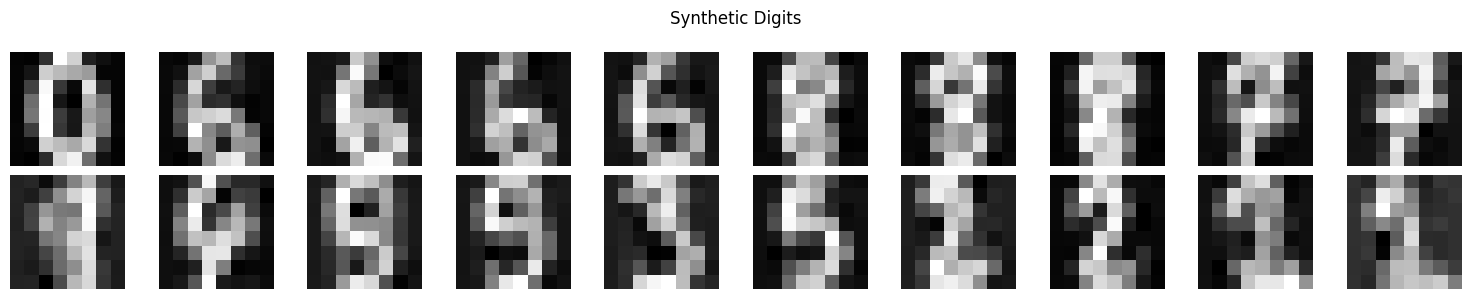


Predicted classes for synthetic digits: [0 6 6 6 6 8 8 8 7 7 1 4 9 9 3 5 2 2 2 2]


In [17]:
# Run experiments for all bottleneck sizes
run_bottleneck_experiments()

Comparison of the results of the autoencoder with bottleneck size 2, 4, and 8 on the digits dataset.

- The autoencoder with bottleneck size 8 has the least reconstruction error, followed by the autoencoder with bottleneck size 4 and 2.

- The autoencoder with bottleneck size 8 has the highest capacity to learn the data distribution and can reconstruct the data most accurately.

- The autoencoder with bottleneck size 2 has the lowest capacity to learn the data distribution and can reconstruct the data least accurately.

Although the autoencoder with bottleneck size 2 has the lowest capacity, it can still recognize the digit labels in the reconstructed data.

Generated synthetic digits are clear and recognizable, and the classifier performs well on the synthetic data.